In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn

def init_plotting():
    plt.rcParams['figure.figsize'] = (14.0,8.0)
    plt.rcParams['font.size'] = 10
    #plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['axes.titlesize'] = 2*plt.rcParams['font.size']
    plt.rcParams['legend.fontsize'] = 0.65*plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['xtick.major.size'] = 3
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['xtick.minor.width'] = 1
    plt.rcParams['ytick.major.size'] = 3
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['ytick.minor.width'] = 1
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.loc'] = 'best'
    plt.rcParams['axes.linewidth'] = 1

init_plotting()

/Users/walterwsmf/bin/anaconda3/envs/astroconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import numpy as np
from pandas import DataFrame, read_csv
from scipy.stats import chisquare
# from numba import jit
# import emcee #MCMC package
from lmfit import Model
import mpyfit
import corner

In [3]:
import occultation_bic

In [4]:
#exoplanetary parameters
a_Rs = 7.986
Rp_Rs = 0.10304
radstar = 0.99
i = 88.01
a = 0.0368
e = 0.0
omega = 0.0
epoch = 2454508.73829
period = 2.61586178
limbB1 = 0.81461289
limbB2 = 0.02619382

In [5]:
#Change for the rigth units
inc = np.radians(i) #inclination in radians
semimajoraxis = a
semimajoraxis = semimajoraxis *1.49598e13 # convert semi-major axis (a) from AU to m
radstar = radstar * 6.955e10 # convert stellar radius from Solar Radii to m
radplanet = radstar * Rp_Rs #calculate planetary radius in m based on Rp/Rs and stellar radius

In [6]:
#reading ICA output 
data = read_csv('./results.ica.csv')

In [7]:
hjd = read_csv('hjd.csv')
hjd = hjd.time.values

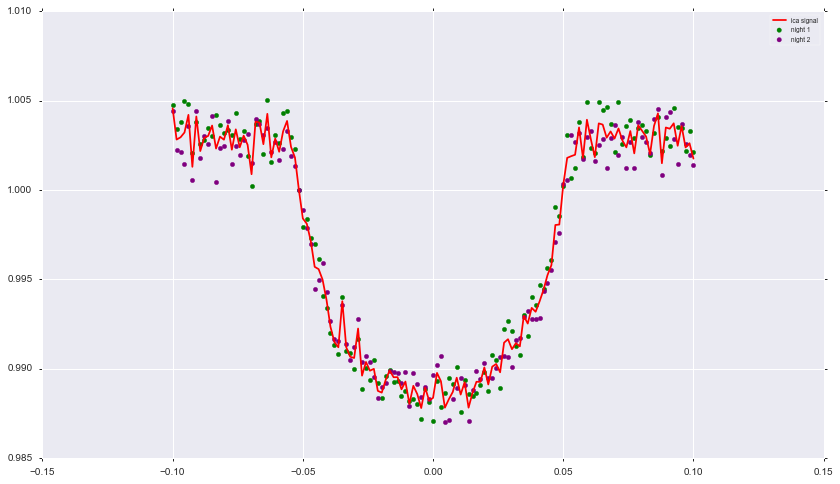

In [8]:
plt.figure()
plt.plot(hjd,data.signal,label='ica signal',color='red')
plt.scatter(hjd,data.obs1,label='night 1',color='green')
plt.scatter(hjd,data.obs2,label='night 2',color='purple')
plt.legend()
# plt.savefig('./signal_vs_observation.pdf')

In [9]:
rawflux = data.signal.values

In [10]:
eflux = 0.001*np.random.normal(size=len(hjd))

In [11]:
X,Y,am = np.loadtxt('XYpos+Airmass.txt',unpack=True)

In [12]:
#lightcurve model

def simple_model(JD, startpar0, startpar1):
    phase = (JD - startpar1)/period
    distance_vector = occultation_bic.delta(phase,inc) * a_Rs
    #model = occultation_fn(distance_vector,startpar0,limbB1,limbB2,show=False)
    model = occultation_bic.occultquad(distance_vector, limbB1, limbB2, startpar0, len(hjd))

    return model

def model_am_exp(hjd,startpar0,startpar1,startpar2,startpar3):
    model = simple_model(hjd,startpar0, startpar1)
    model_am = model * startpar2 * np.exp(-1. * startpar3 * am) #multiply light curve by factor x exponential
    return model_am

In [13]:
lc_model = Model(model_am_exp)

In [14]:
np.mean(hjd)

0.0

In [15]:
result = lc_model.fit(rawflux, hjd=hjd, startpar0 = 0.1001, startpar1 = np.mean(hjd), startpar2 = 1., startpar3 = 0.)

In [16]:
print(result.fit_report())

[[Model]]
    Model(model_am_exp)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 133
    # variables        = 4
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -1919.907
    Bayesian info crit = -1908.345
[[Variables]]
    startpar0:   0.10354838 +/- 0.000562 (0.54%) (init= 0.1001)
    startpar1:  -0.00049682 +/- 0.000244 (49.06%) (init= 0)
    startpar2:   1.00270549 +/- 0.000573 (0.06%) (init= 1)
    startpar3:  -0.00019573 +/- 0.000457 (233.66%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(startpar2, startpar3)      =  0.988 
    C(startpar0, startpar2)      =  0.425 
    C(startpar1, startpar3)      =  0.336 
    C(startpar1, startpar2)      =  0.332 
    C(startpar0, startpar3)      =  0.330 
    C(startpar0, startpar1)      =  0.111 



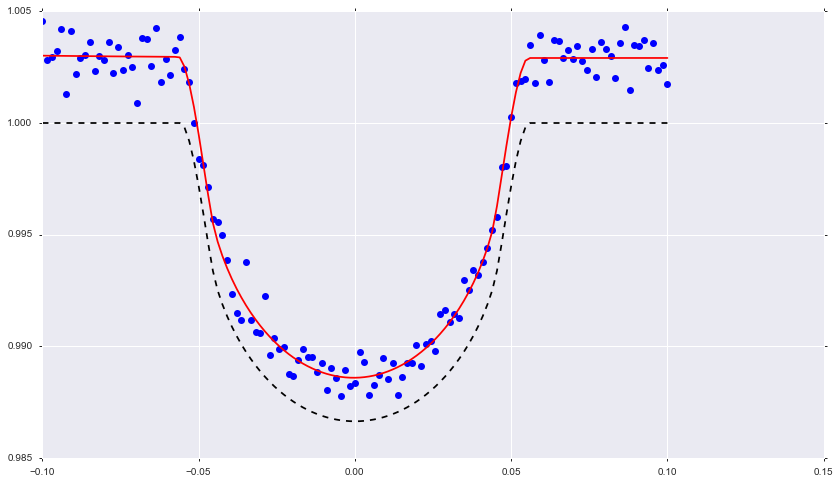

In [17]:
plt.plot(hjd, rawflux,         'bo')
plt.plot(hjd, result.init_fit, 'k--')
plt.plot(hjd, result.best_fit, 'r-')

In [21]:
result.best_values['startpar0']

{'startpar0': 0.10354838259723849,
 'startpar1': -0.00049681720202617919,
 'startpar2': 1.0027054971349447,
 'startpar3': -0.00019573315584926561}